In [50]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('notebook')

from glob import glob
from os import path
import os
from multiprocessing import Pool

import vg

from collections import defaultdict, namedtuple

import sqlite3

import sys
sys.path.insert(1, '../src/')
from mythicwind.gps import *
from mythicwind.csv_io import *

data_dir = '../data'
turbine_data_dir = '../data/turbines/'
results_dir = '../results'

# selected_turbines = [f'turbine-{i:02d}' for i in range(4, 17)]
selected_turbines = [f'turbine-{i:02d}' for i in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def find_installation_times(turbine_dataset, sbi_altitude_limit=90, buffer_timedelta=pd.to_timedelta('30min'), resample_period='1s', smoothing_period='20min', selection_threshold=pd.to_timedelta('60s')):

    sbi_times = list() # used to store pairs of single blade installation start/stop datetimes
    
    hh, sr, st = (turbine_dataset.helihoist.altitude.resample(resample_period).mean().rolling(smoothing_period).mean(), 
                  turbine_dataset.sbitroot.altitude.resample(resample_period).mean().rolling(smoothing_period).mean(), 
                  turbine_dataset.sbittip.altitude.resample(resample_period).mean().rolling(smoothing_period).mean(),
                 )

    hammerhead_start = hh[hh > sbi_altitude_limit].index[0] + buffer_timedelta

    hh_sbi = hh[(hh > sbi_altitude_limit) & (sr > sbi_altitude_limit) & (st > sbi_altitude_limit)]
    
    if len(hh_sbi) == 0:
        print(f'failed to identify sbi times')
        print(f'trying only with sbitroot')
        hh_sbi = hh[(hh > sbi_altitude_limit) & (sr > sbi_altitude_limit)]
        
        if len(hh_sbi) == 0:
            print(f'failed to identify sbi times only using sbitroot')
            print(f'trying only with sbittip')
            hh_sbi = hh[(hh > sbi_altitude_limit) & (st > sbi_altitude_limit)]
            
            if len(hh_sbi) == 0:
                print(f'failed to identify sbit times only using sbittip')
                print(f'stopping')
                raise Exception('failed to identify blade landings')
    
    ii = hh_sbi[hh_sbi.index.to_series().diff() > selection_threshold].index.to_list()
    
    ii.insert(0, hh_sbi.index[0])
    ii.insert(len(ii), hh_sbi.index[-1])    

    for i in range(len(ii) - 1):
        sbi_times.append((ii[i] - pd.to_timedelta(smoothing_period)/2, hh_sbi[ii[i]:ii[i+1]].index[-2] - pd.to_timedelta(smoothing_period)/2 ))
    
    return sbi_times


def find_hammerhead_times(turbine_dataset, first_sbi=None, altitude_limit=90, buffer_timedelta=pd.to_timedelta('30min'), resample_period='1s', smoothing_period='20min'):
    
    if not first_sbi:
        try:
            sbi_times = find_installation_times(turbine_dataset, sbi_altitude_limit=altitude_limit, buffer_timedelta=buffer_timedelta, resample_period=resample_period, smoothing_period=smoothing_period)
            print(f'found first sbi: {sbi_times[0][0]}')
        except:
            raise Exception(f'failed to identify blade landings, please provide manual blade landing datetime')   
        
        first_sbi = sbi_times[0][0]

    hh = turbine_dataset.helihoist.altitude.resample(resample_period).mean().rolling(smoothing_period).mean()    
    
    hammerhead_start = hh[hh > altitude_limit].index[0] + buffer_timedelta
    
    return(hammerhead_start, first_sbi)
    
    
def plot_sbi_times(turbine_dataset, sbi_times, blade_landings):
    plt.figure()    

    plt.plot(turbine_dataset.helihoist.altitude, alpha=0.25, label='helihoist', color='tab:blue')
    plt.plot(turbine_dataset.sbitroot.altitude, alpha=0.25, label='sbitroot', color='tab:orange')
    plt.plot(turbine_dataset.sbittip.altitude, alpha=0.25, label='sbittip', color='tab:green')

    if not sbi_times:
        return
    
    for (start, end) in sbi_times:
        plt.plot(turbine_dataset.helihoist[start:end].altitude, color='tab:blue')
        plt.plot(turbine_dataset.sbitroot[start:end].altitude, color='tab:orange')
        plt.plot(turbine_dataset.sbittip[start:end].altitude, color='tab:green')
    
        for blade_landing_i, blade_landing in enumerate(blade_landings):
            print(blade_landing_i)
            plt.axvspan(xmin=start, xmax=end, hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
            if blade_landing > start and blade_landing < end:
                plt.axvline(x=blade_landing, color='tab:purple', linewidth=2, label=f'successfull blade landing {blade_landing_i}')
                if blade_landing_i == 0:
                    print(f'first successful blade landing')
                    hammerhead_end = blade_landing - pd.to_timedelta('30min')
                    plt.axvspan(xmin=hammerhead_start, xmax=hammerhead_end, label='hammerhead configuration', facecolor='white', alpha=0.25, edgecolor='tab:green', hatch='//')
    plt.tight_layout()
    plt.ylabel('altitude (m)')
    plt.legend(loc='upper left')
    plt.show()

## Installation times from time-tracking

In [43]:
blade_installations = defaultdict(list)
blade_landings = defaultdict(dict)
TNHBx = defaultdict(dict)
hammerheads = dict()

install_db = sqlite3.connect(path.join(data_dir, 'installation_times/installation_times.sqlite'))
install_db_cur = install_db.cursor()

for (turbine_name, blade_number, start_epoch, end_epoch) in install_db_cur.execute('SELECT turbine_name, blade_number, blade_installation_start_epoch, blade_installation_end_epoch FROM blade_installation_success WHERE turbine_id < 17'):
    start = pd.to_datetime(start_epoch, unit='s', utc=True)
    end = pd.to_datetime(end_epoch, unit='s', utc=True)
    delta_t = end-start

    blade_installations[turbine_name].append((start, end))
    
for (turbine_name, blade_number, blade_landing) in install_db_cur.execute('SELECT turbine_name, blade_number, blade_landing_epoch FROM blade_landings_full'):
    blade_landings[turbine_name][blade_number] = pd.to_datetime(blade_landing, unit='s', utc=True)

for turbine_name, installation in blade_installations.items():
    print(f'{turbine_name} TNHB1: {blade_installations[turbine_name][0][1]} -> {blade_installations[turbine_name][1][0]}')
    TNHBx[turbine_name]['TNHB1'] = (blade_installations[turbine_name][0][1], blade_installations[turbine_name][1][0])
    
    print(f'{turbine_name} TNHB2: {blade_installations[turbine_name][1][1]} -> {blade_installations[turbine_name][2][0]}')
    TNHBx[turbine_name]['TNHB2'] = (blade_installations[turbine_name][1][1], blade_installations[turbine_name][2][0])

turbine-01 TNHB1: 2019-08-05 10:00:00+00:00 -> 2019-08-09 04:30:00+00:00
turbine-01 TNHB2: 2019-08-09 08:00:00+00:00 -> 2019-08-12 23:00:00+00:00
turbine-02 TNHB1: 2019-08-21 23:30:00+00:00 -> 2019-08-23 11:00:00+00:00
turbine-02 TNHB2: 2019-08-23 13:30:00+00:00 -> 2019-08-23 16:00:00+00:00
turbine-03 TNHB1: 2019-08-26 00:00:00+00:00 -> 2019-08-26 03:15:00+00:00
turbine-03 TNHB2: 2019-08-26 10:00:00+00:00 -> 2019-08-26 13:15:00+00:00
turbine-04 TNHB1: 2019-09-07 12:30:00+00:00 -> 2019-09-08 04:30:00+00:00
turbine-04 TNHB2: 2019-09-08 21:35:00+00:00 -> 2019-09-09 03:00:00+00:00
turbine-05 TNHB1: 2019-09-20 07:17:00+00:00 -> 2019-09-20 11:47:00+00:00
turbine-05 TNHB2: 2019-09-20 12:50:00+00:00 -> 2019-09-20 16:10:00+00:00
turbine-06 TNHB1: 2019-09-22 12:23:00+00:00 -> 2019-09-22 21:53:00+00:00
turbine-06 TNHB2: 2019-09-23 00:10:00+00:00 -> 2019-09-23 11:15:00+00:00
turbine-07 TNHB1: 2019-09-25 13:45:00+00:00 -> 2019-09-25 18:00:00+00:00
turbine-07 TNHB2: 2019-09-25 21:00:00+00:00 -> 2019

## Installation times from GNSS

In [5]:
keymap = {'helihoist-1' : 'hh',
          'sbitroot'    : 'sr',
          'sbittip'     : 'st',
         }

GNSS_dataset = namedtuple('GNSS_dataset', ['helihoist', 'sbitroot', 'sbittip'])

turbines = dict()

for turbine_path in sorted(glob(path.join(turbine_data_dir, f'turbine-??'))):
    
    turbine_id = turbine_path.split('/')[3]
   
    if turbine_id not in selected_turbines:
        print(f'skipping {turbine_id}')
        continue

    print(f'processing {turbine_id}')
        
    gnss_data_temp = {'helihoist-1' : None,
                      'sbitroot'  : None,
                      'sbittip'   : None,
                     }
    
    for pos in ('helihoist-1', 'sbitroot', 'sbittip'):
        
        print(f'processing {turbine_id}/{pos}')
        
        gps_file_path = path.join(path.join(turbine_path, pos), f'tom/gps/{turbine_id}_{pos}_tom_gps.csv')
        
        if path.isfile(gps_file_path):
                        
            gnss_data_temp[pos] = read_frame(gps_file_path)
    
    turbines[turbine_id] = GNSS_dataset(gnss_data_temp['helihoist-1'], gnss_data_temp['sbitroot'], gnss_data_temp['sbittip'])
    
    

skipping turbine-01
skipping turbine-02
skipping turbine-03
processing turbine-04
processing turbine-04/helihoist-1
processing turbine-04/sbitroot
processing turbine-04/sbittip
processing turbine-05
processing turbine-05/helihoist-1
processing turbine-05/sbitroot
processing turbine-05/sbittip
processing turbine-06
processing turbine-06/helihoist-1
processing turbine-06/sbitroot
processing turbine-06/sbittip
processing turbine-07
processing turbine-07/helihoist-1
processing turbine-07/sbitroot
processing turbine-07/sbittip
processing turbine-08
processing turbine-08/helihoist-1
processing turbine-08/sbitroot
processing turbine-08/sbittip
processing turbine-09
processing turbine-09/helihoist-1
processing turbine-09/sbitroot
processing turbine-09/sbittip
processing turbine-10
processing turbine-10/helihoist-1
processing turbine-10/sbitroot
processing turbine-10/sbittip
processing turbine-11
processing turbine-11/helihoist-1
processing turbine-11/sbitroot
processing turbine-11/sbittip
proc

4 turbine-04


<IPython.core.display.Javascript object>


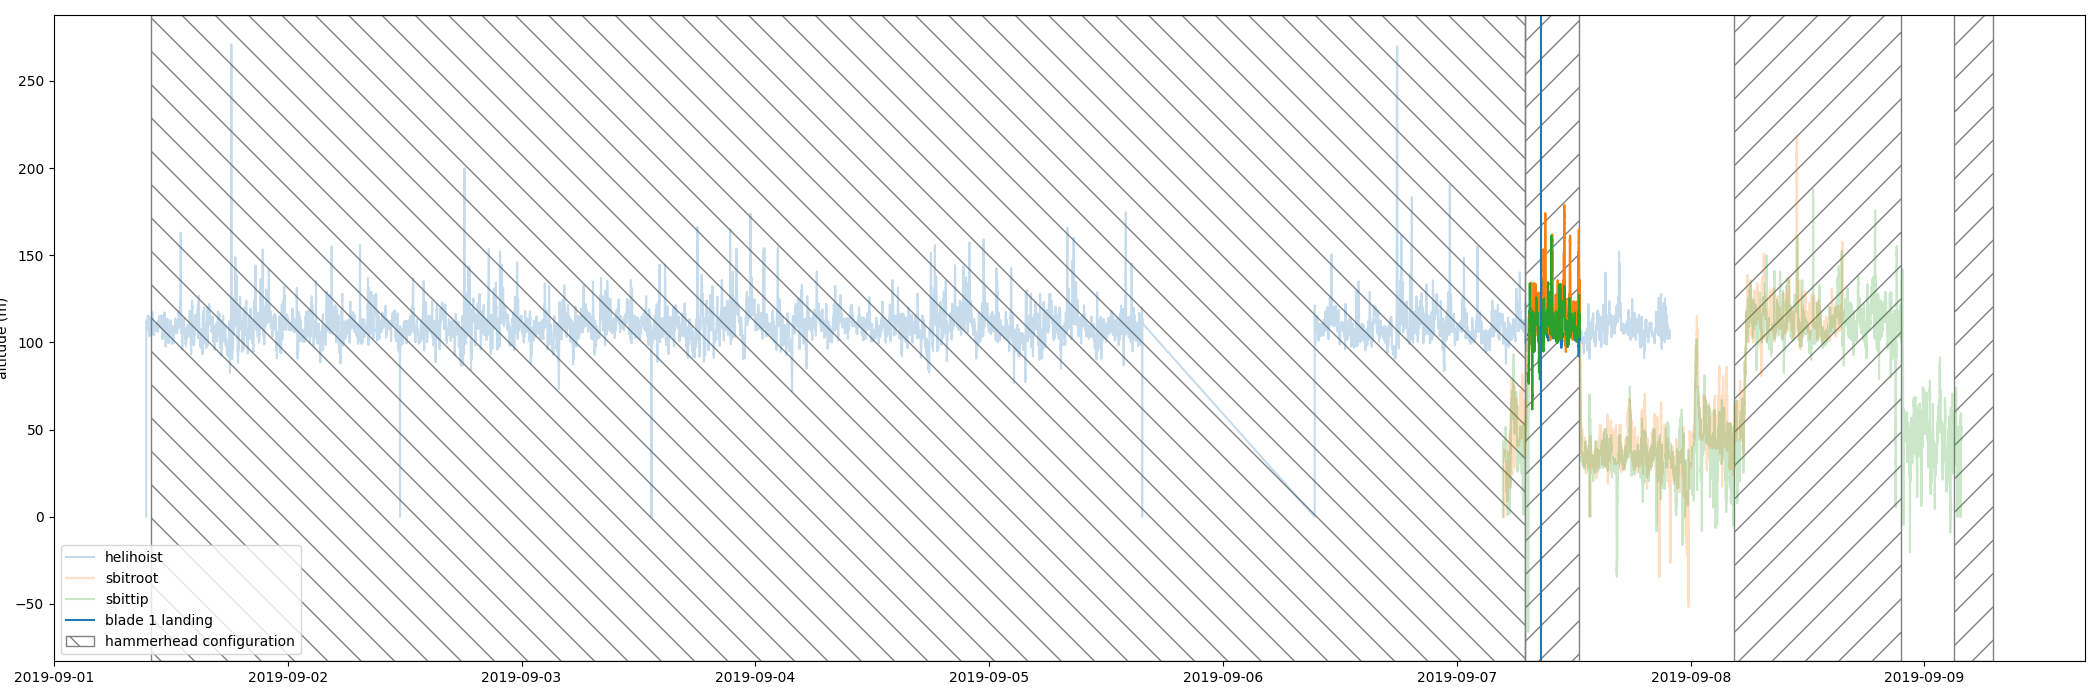

5 turbine-05


<IPython.core.display.Javascript object>


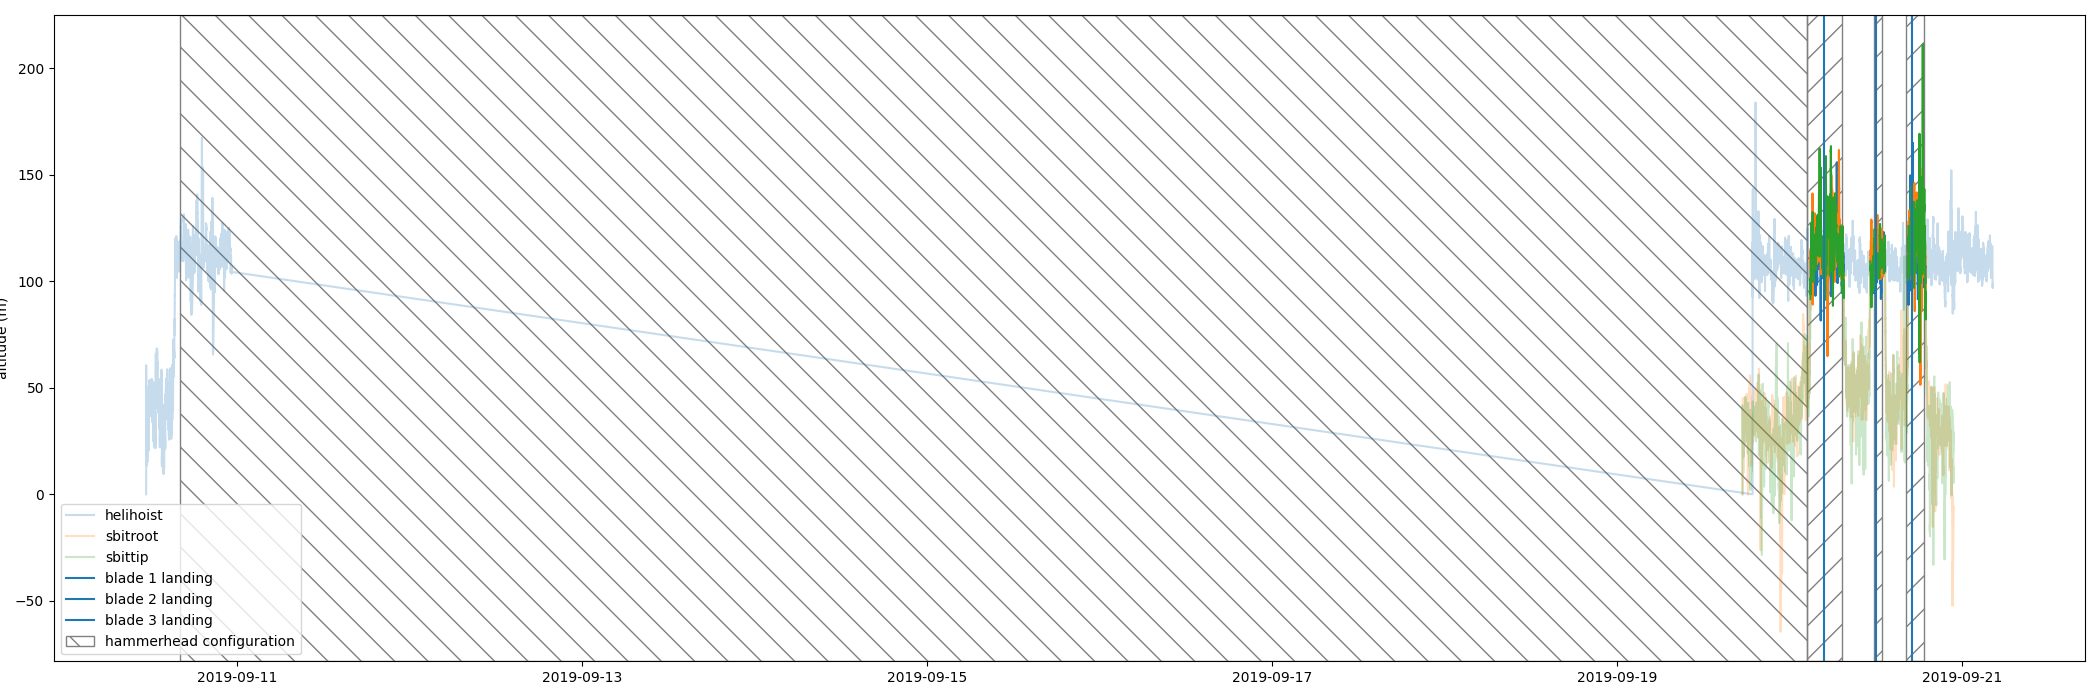

6 turbine-06


<IPython.core.display.Javascript object>


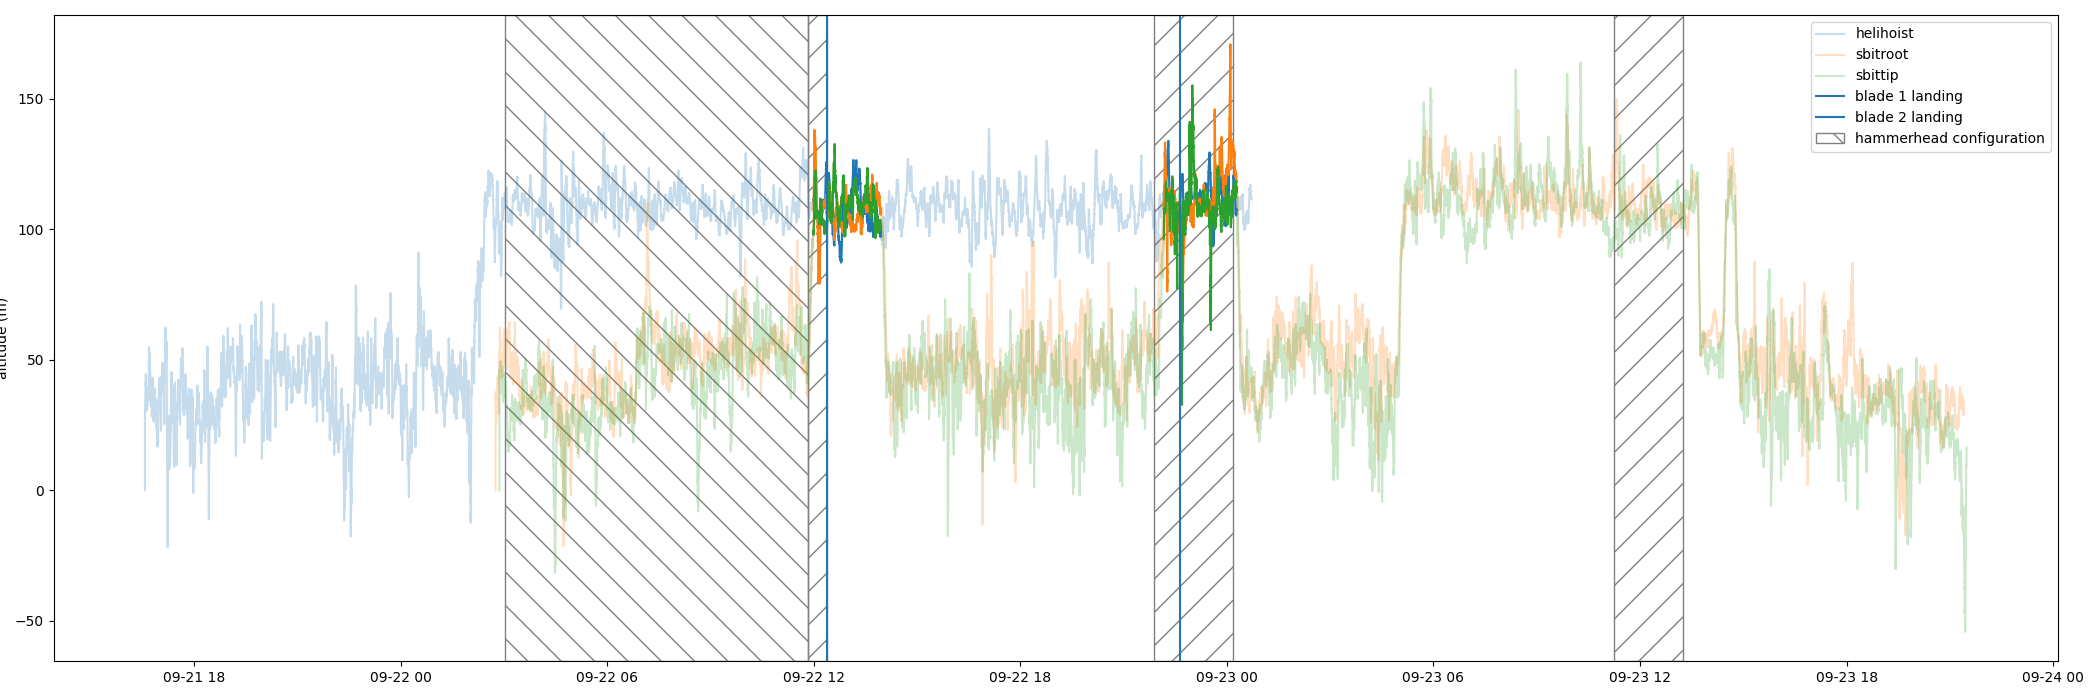

7 turbine-07
failed to identify sbi times
trying only with sbitroot


<IPython.core.display.Javascript object>


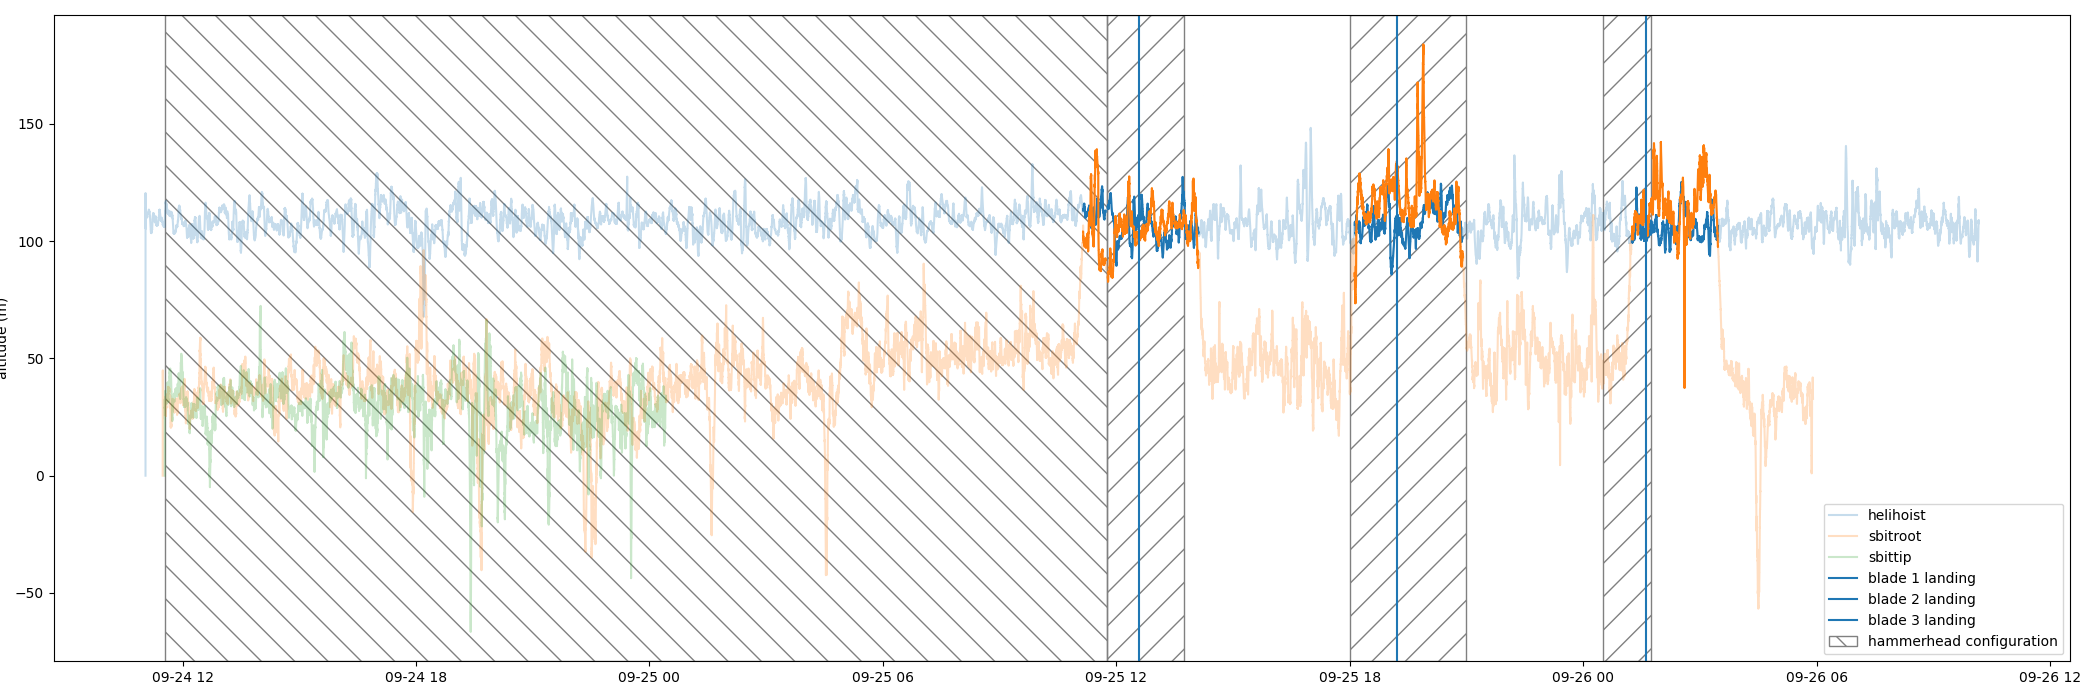

8 turbine-08


<IPython.core.display.Javascript object>


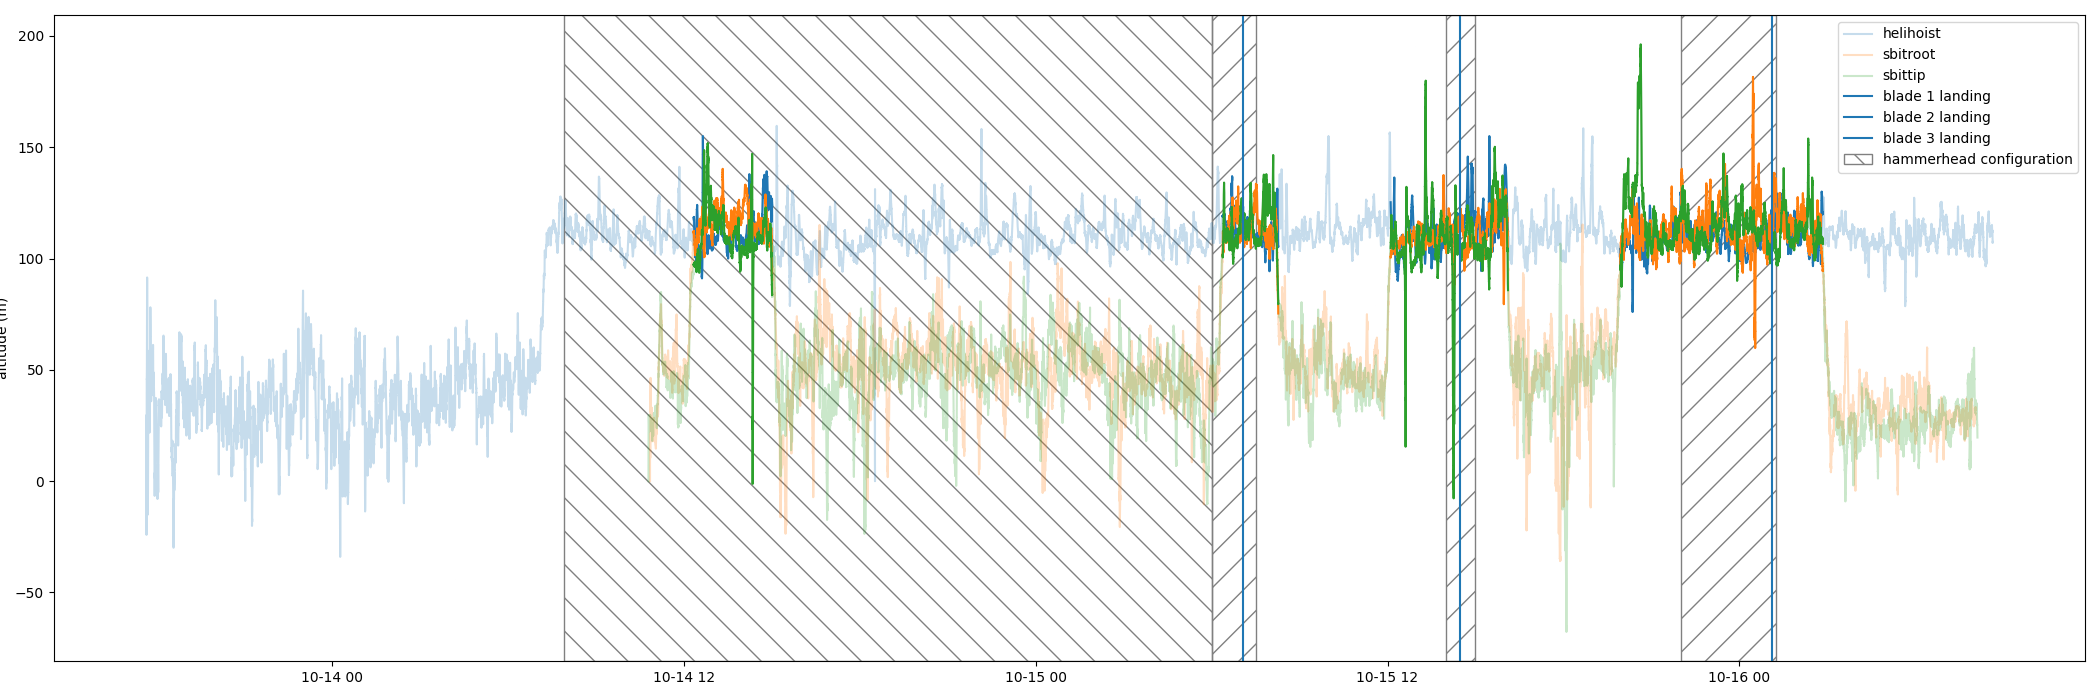

9 turbine-09
failed to identify sbi times
trying only with sbitroot
failed to identify sbi times only using sbitroot
trying only with sbittip
failed to identify sbit times only using sbittip
stopping
failed to find times for turbine-09, skipping


<IPython.core.display.Javascript object>


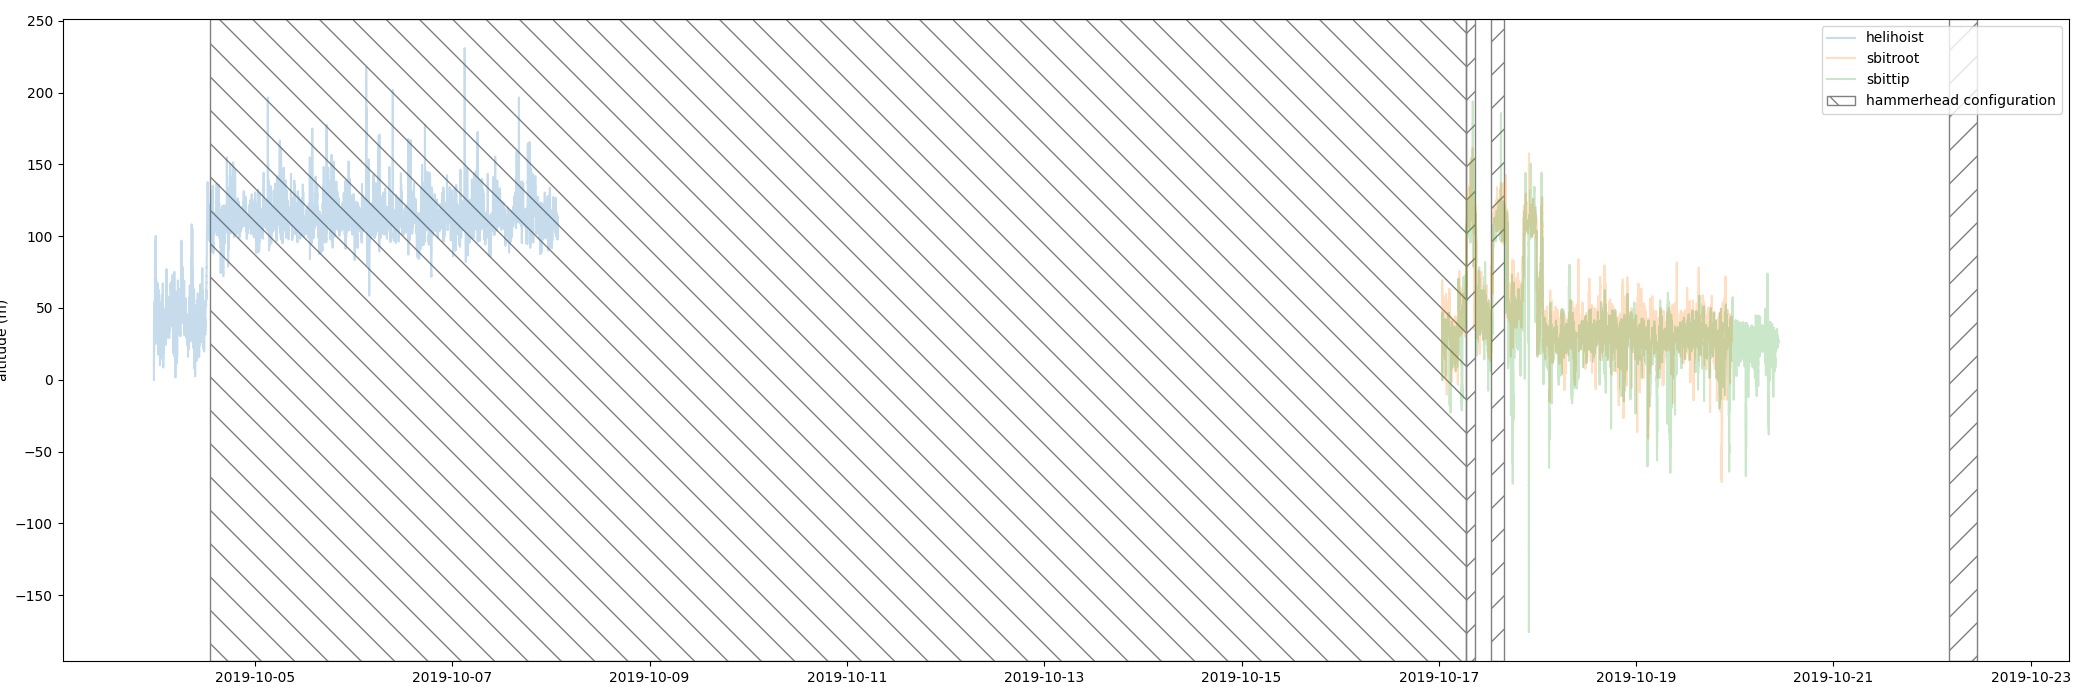

10 turbine-10


<IPython.core.display.Javascript object>


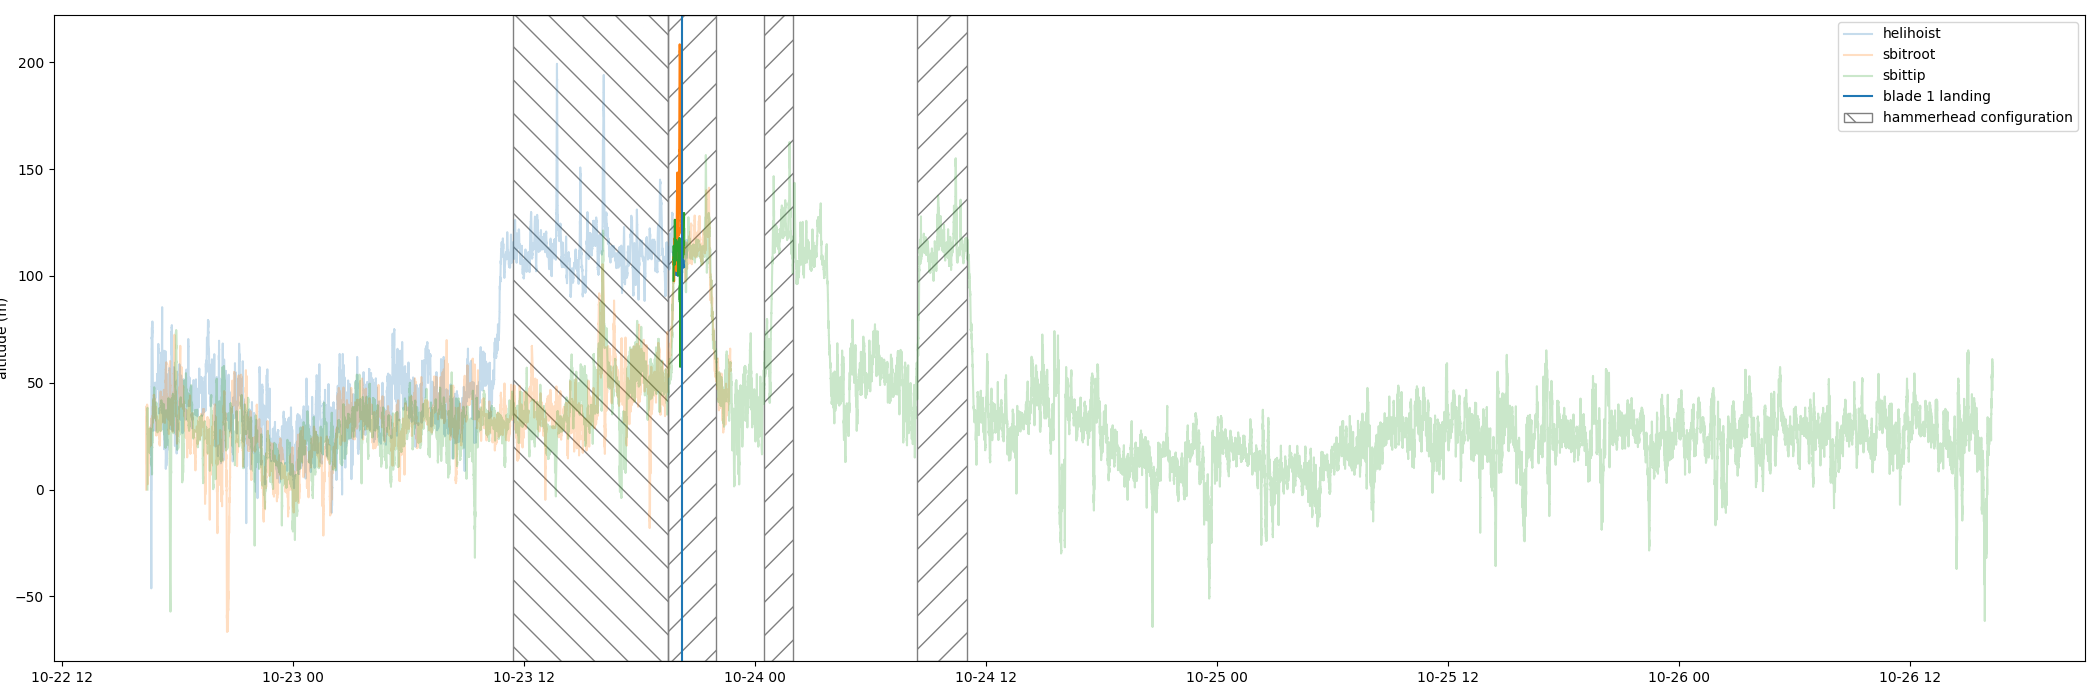

11 turbine-11


<IPython.core.display.Javascript object>


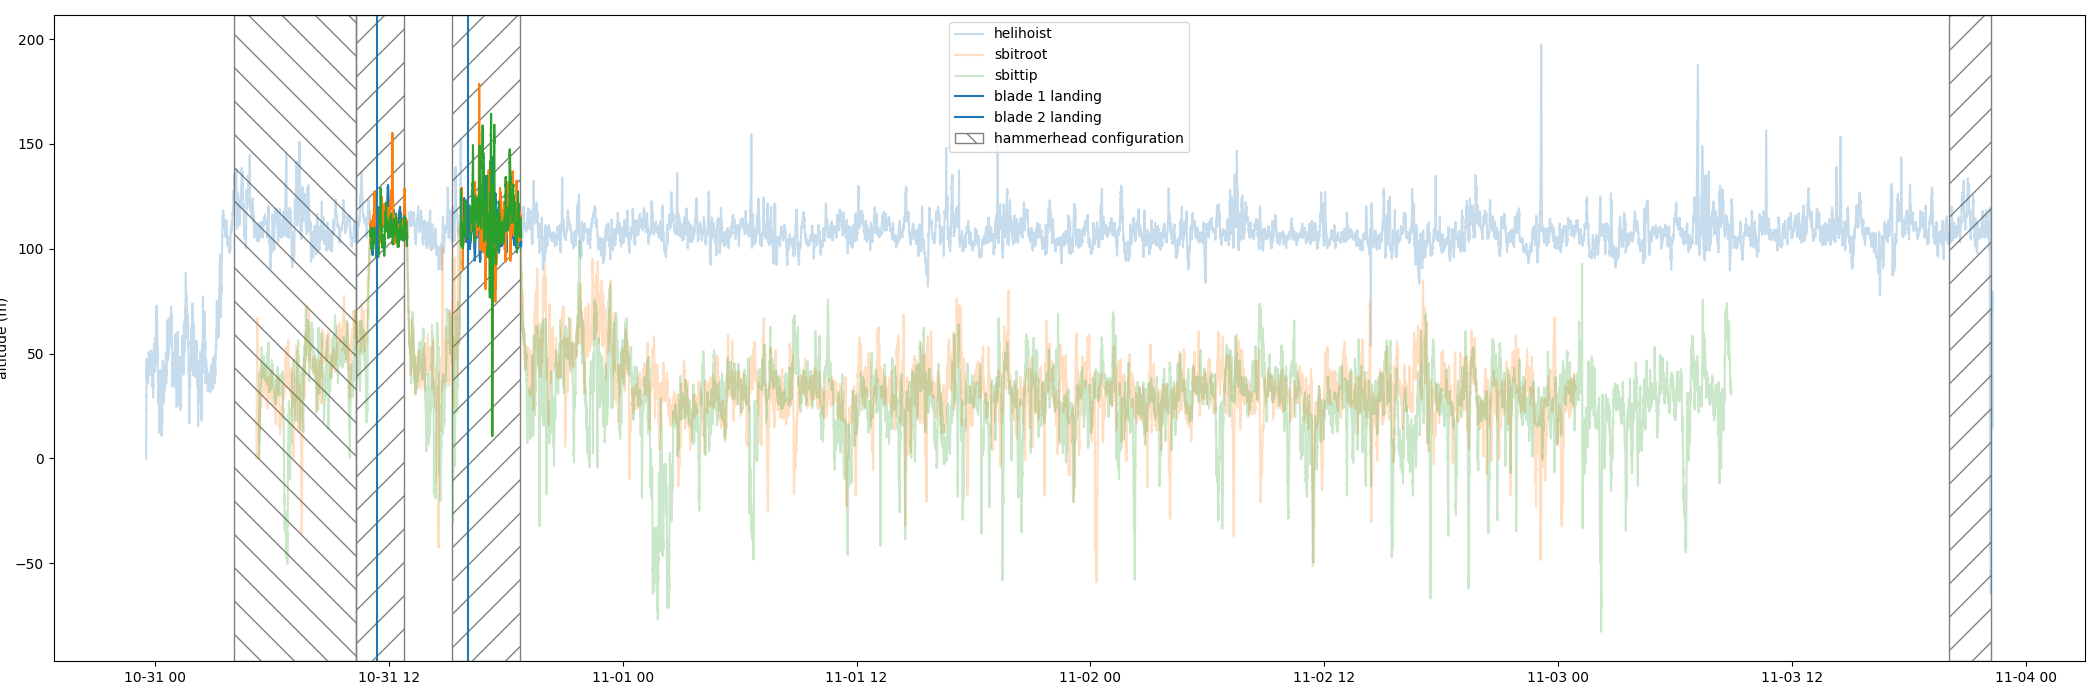

12 turbine-12


<IPython.core.display.Javascript object>


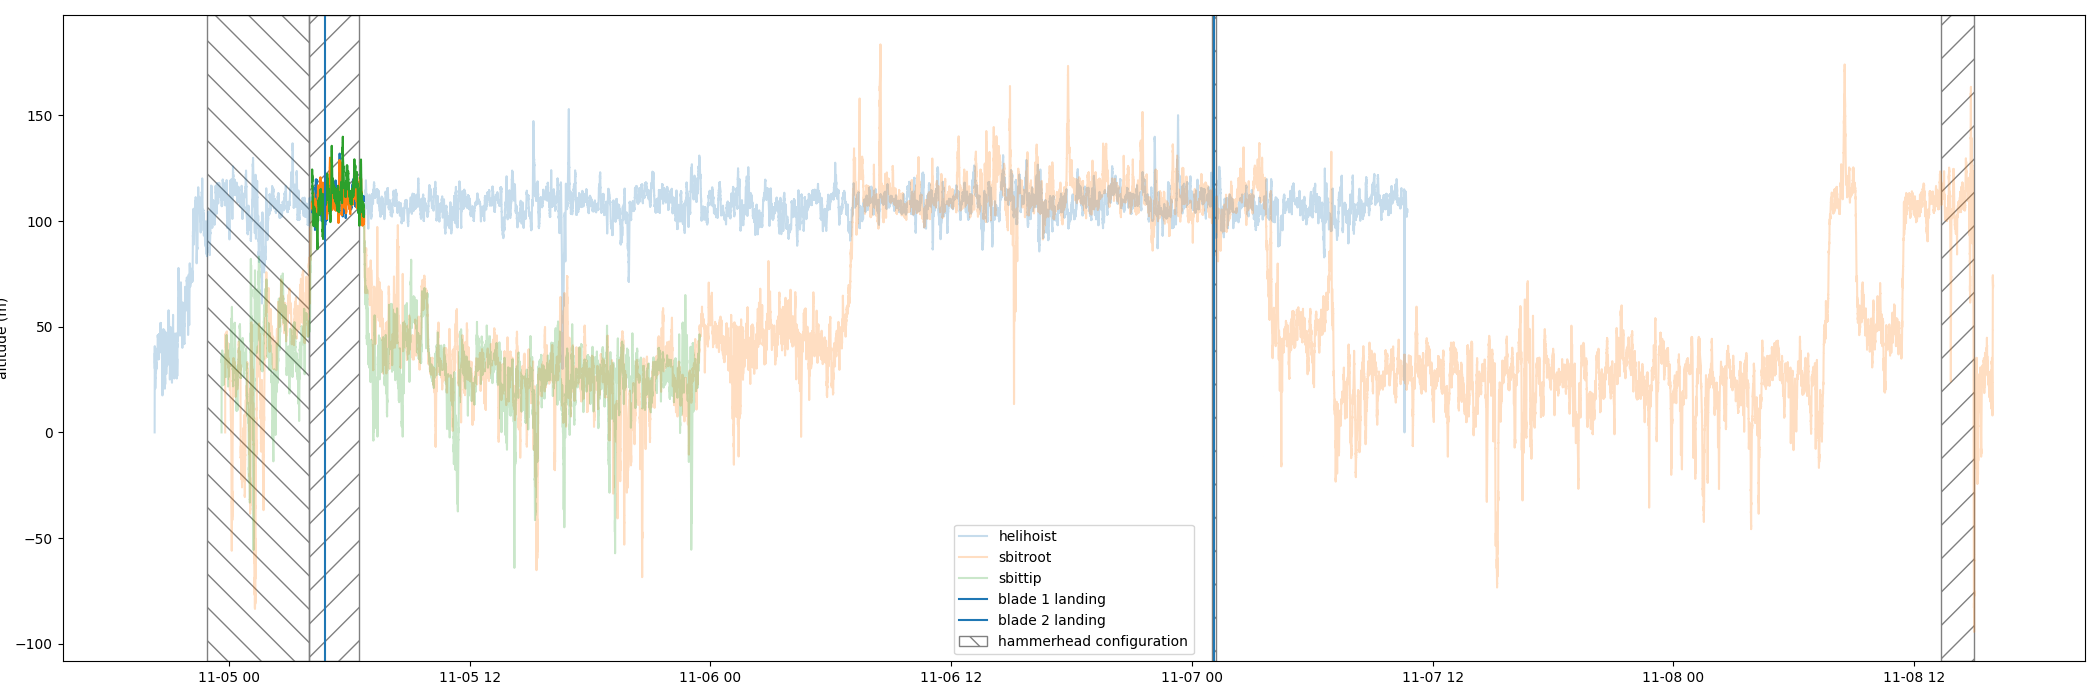

13 turbine-13
failed to identify sbi times
trying only with sbitroot


<IPython.core.display.Javascript object>


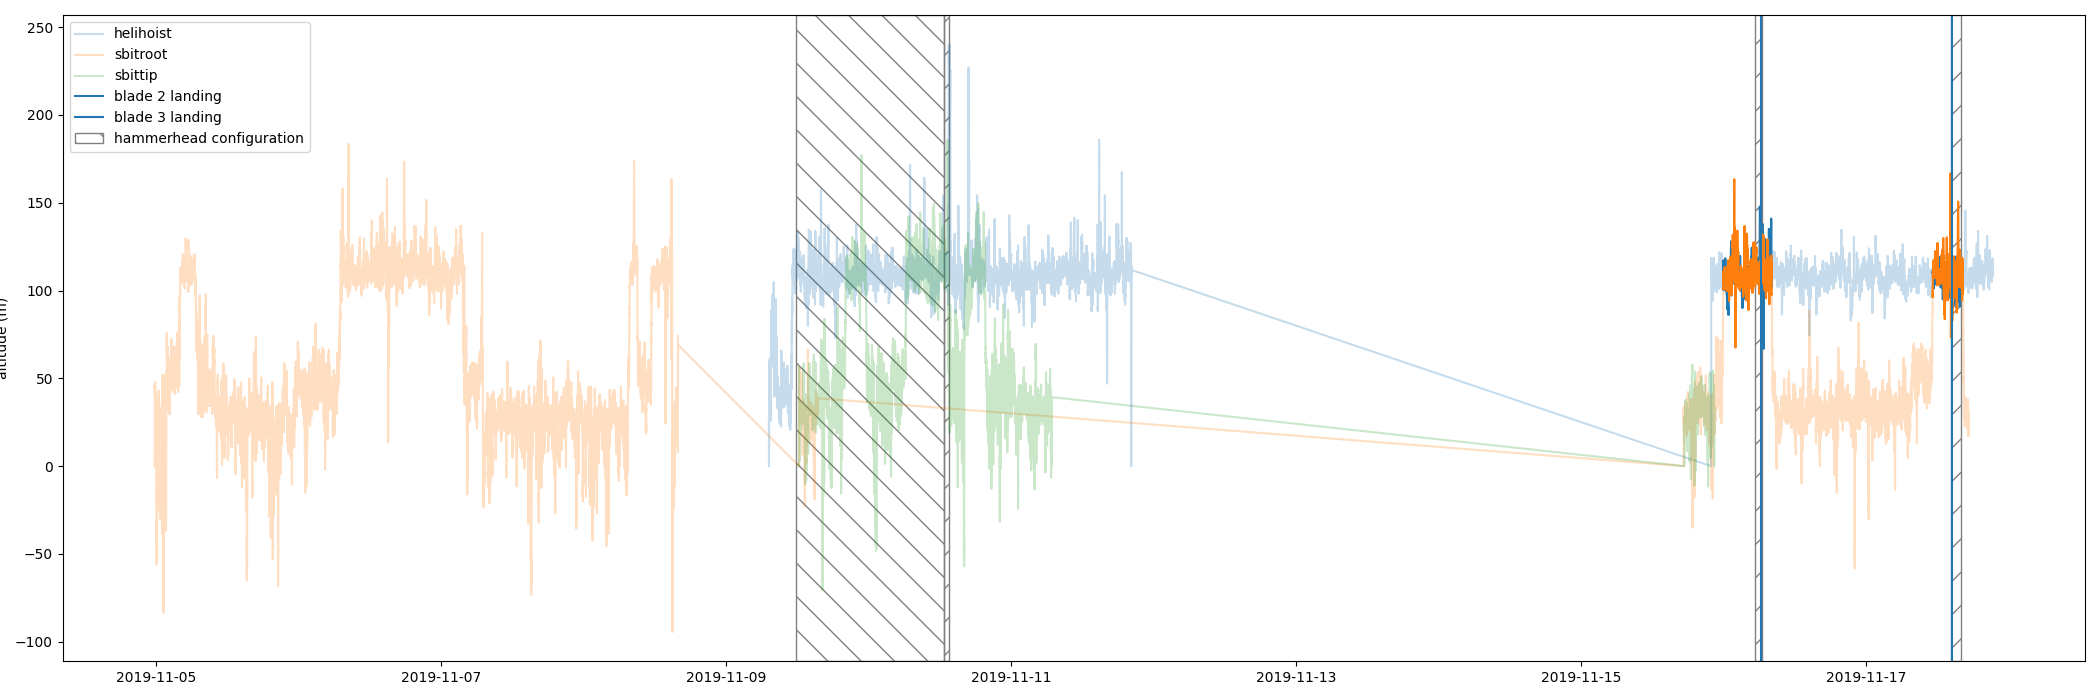

14 turbine-14


<IPython.core.display.Javascript object>


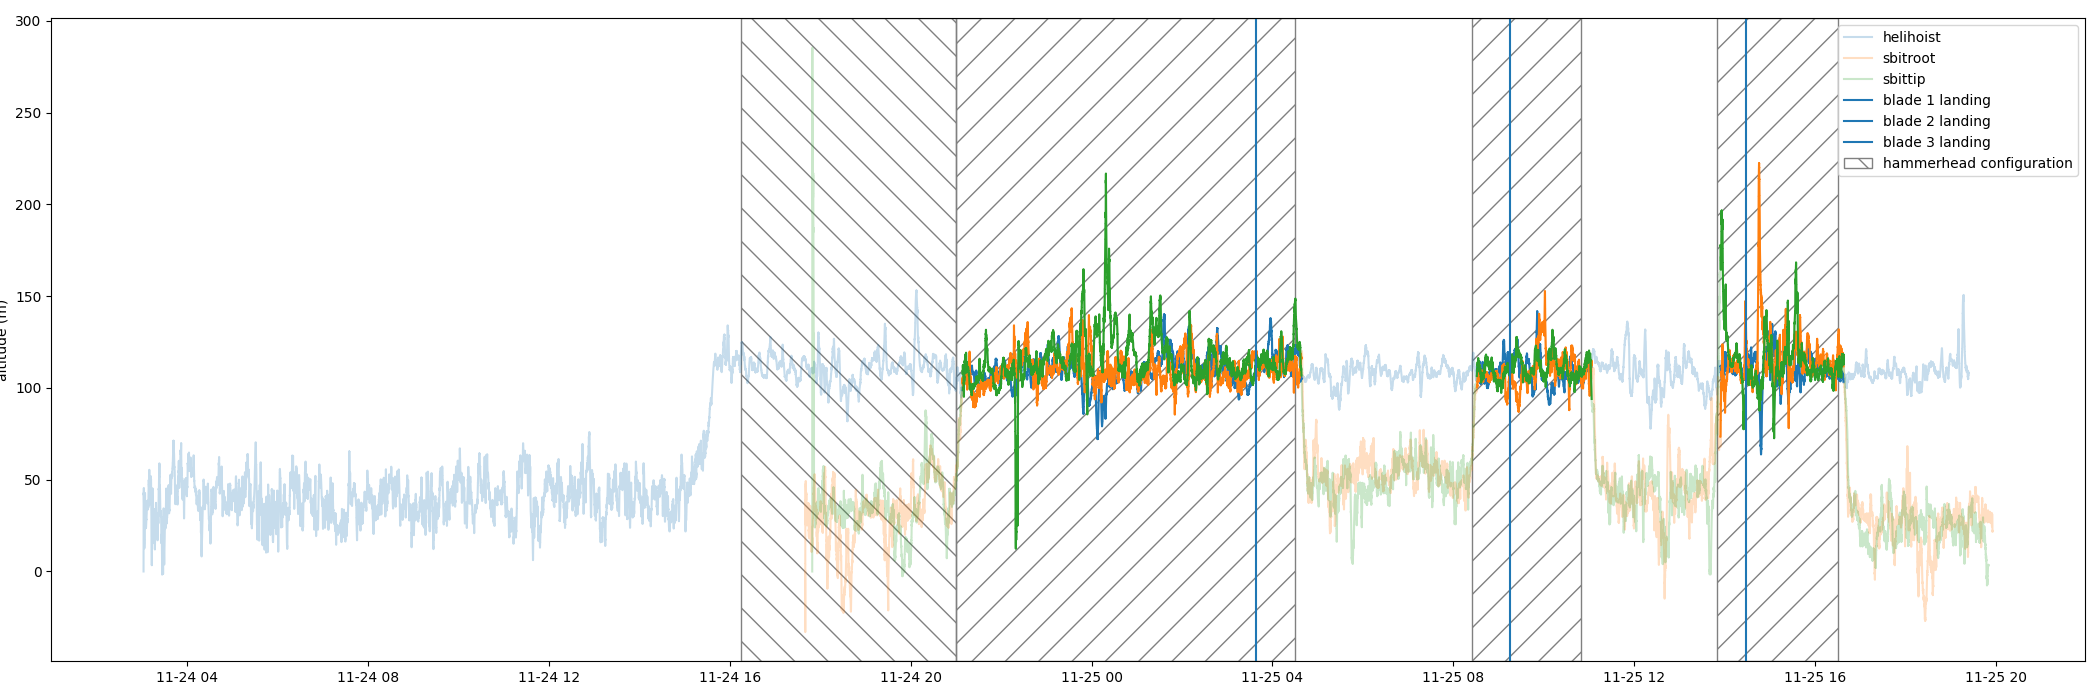

16 turbine-16
failed to identify sbi times
trying only with sbitroot
failed to identify sbi times only using sbitroot
trying only with sbittip
failed to identify sbit times only using sbittip
stopping
failed to find times for turbine-16, skipping


<IPython.core.display.Javascript object>


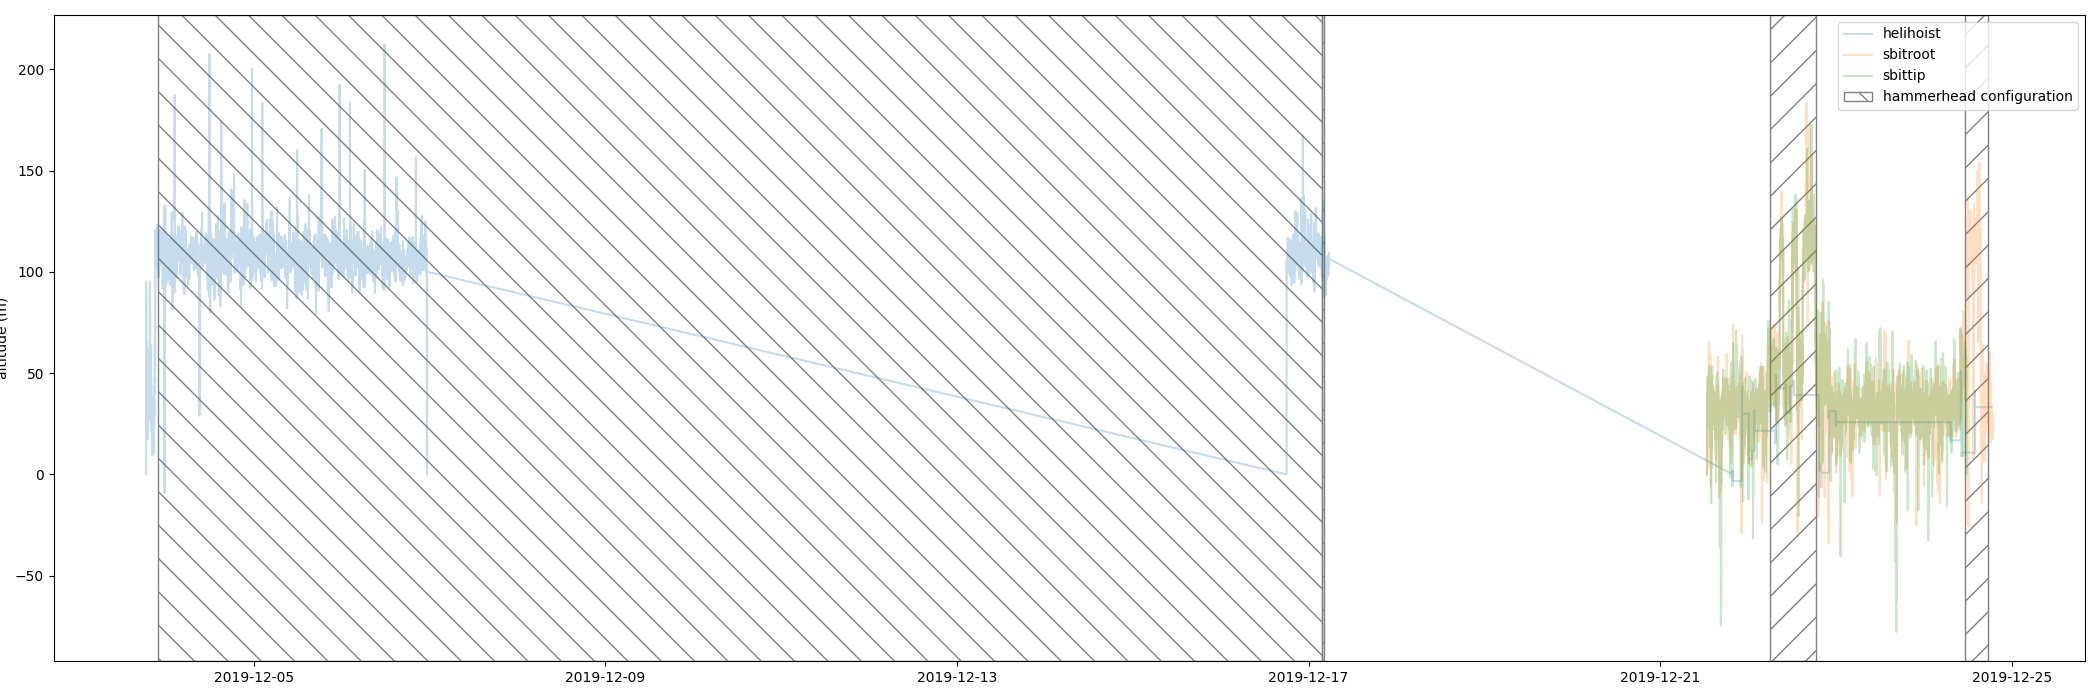

In [44]:
try:
    configuration_file = open('../data/installation_times/turbine_configurations.csv', 'w')
except Execption as e:
    print(f'failed to open file: {e}')

configuration_file.write(f'turbine_id,hammerhead_start_epoch,hammerhead_end_epoch,TNHB1_start_epoch,TNHB1_end_epoch,TNHB2_start_epoch,TNHB2_end_epoch\n')

for (turbine_name, turbine_dataset) in turbines.items():
    
    turbine_id = int(turbine_name.split('-')[-1])
    
    print(turbine_id, turbine_name)
        
    try:
        sbi_times = find_installation_times(turbine_dataset)
    except:
        print(f'failed to find times for {turbine_name}, skipping')
        
    plot_sbi_times(turbine_dataset, sbi_times, [])
    
    hammerhead_start, hammerhead_end = find_hammerhead_times(turbine_dataset, first_sbi=blade_installations[turbine_name][0][0])
    
    hammerheads[turbine_name] = (hammerhead_start, hammerhead_end)
    
    configuration_file.write(f'{turbine_name},{int(hammerhead_start.timestamp())},{int(hammerhead_end.timestamp())},{int(TNHBx[turbine_name]["TNHB1"][0].timestamp())},{int(TNHBx[turbine_name]["TNHB1"][1].timestamp())},{int(TNHBx[turbine_name]["TNHB2"][0].timestamp())},{int(TNHBx[turbine_name]["TNHB2"][1].timestamp())}\n')
    
    plt.axvspan(xmin=hammerhead_start, xmax=hammerhead_end, facecolor='None', edgecolor='grey', hatch='\\', label='hammerhead configuration')
    
    for (start, end) in blade_installations[turbine_name]:
        plt.axvspan(xmin=start, xmax=end, facecolor='None', edgecolor='grey', hatch='/')
        
    if turbine_name in blade_landings:
        for blade, blade_landing in blade_landings[turbine_name].items():
            plt.axvline(x=blade_landing, label=f'blade {blade} landing')
            
    plt.legend()
    
configuration_file.close()

### writing hammerhead data 

In [52]:
for turbine_path in sorted(glob(path.join(turbine_data_dir, f'turbine-??'))):
    
    turbine_name = turbine_path.split('/')[3]
   
    if turbine_name not in selected_turbines:
        print(f'skipping {turbine_name}')
        continue

    print(f'processing {turbine_name}')
        
    for pos in ('helihoist-1', 'sbitroot', 'sbittip'):
        
        pos_dir = path.join(turbine_path, pos)
        
        print(f'processing {pos_dir}')
        
        hammerhead_data = list()
        
        for datafile in sorted(glob(f'{pos_dir}/tom/acc-vel-pos/{turbine_name}_{pos}_tom_acc-vel-pos_*.csv')):
            start, end = datafile.split('/')[-1].split('.')[0].split('_')[4:6]
            start = pd.to_datetime(start, format='%Y-%m-%d-%H-%M-%S', utc=True)
            end = pd.to_datetime(end, format='%Y-%m-%d-%H-%M-%S', utc=True)
            
            if start < hammerheads[turbine_name][0] and start < hammerheads[turbine_name][1]:
                continue
            elif start > hammerheads[turbine_name][0] and start < hammerheads[turbine_name][1]:
                print(f'{turbine_name}: found hammerhead data file: {datafile} -> {start}, {end}')
                hammerhead_data.append(read_frame(datafile))
            else:
                continue
        
        if len(hammerhead_data) == 0:
            print('could not find matching data!')
            continue
        
        hammerhead_data = pd.concat(hammerhead_data)
        hammerhead_data.sort_index(inplace=True)
        
        target_dir = path.join(pos_dir, 'tom/acc-vel-pos/hammerhead')
        
        if not path.isdir(target_dir):
            try:
                os.mkdir(target_dir)
            except Exception as e:
                print(f'failed to create path: {e}')
        
        record_start = hammerhead_data.index[0].strftime('%Y-%m-%d-%H-%M-%S')
        record_end = hammerhead_data.index[-1].strftime('%Y-%m-%d-%H-%M-%S')
        outfile_name = f'{turbine_name}_{pos}_tom_acc-vel-pos_hammerhead_{record_start}_{record_end}.csv'
        outfile_path = path.join(target_dir, outfile_name)
        print(f'export data to: {outfile_path}')
        
        write_frame(hammerhead_data, outfile_path)
        
        
        

skipping turbine-01
skipping turbine-02
skipping turbine-03
processing turbine-04
processing ../data/turbines/turbine-04/helihoist-1
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-01-10-20-45_2019-09-01-10-47-22.csv -> 2019-09-01 10:20:45+00:00, 2019-09-01 10:47:22+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-01-10-47-22_2019-09-01-11-14-00.csv -> 2019-09-01 10:47:22+00:00, 2019-09-01 11:14:00+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-01-11-14-01_2019-09-01-11-40-40.csv -> 2019-09-01 11:14:01+00:00, 2019-09-01 11:40:40+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-01-11-40-40_2019-09

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-01-25-27_2019-09-02-01-50-33.csv -> 2019-09-02 01:25:27+00:00, 2019-09-02 01:50:33+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-01-50-33_2019-09-02-02-15-39.csv -> 2019-09-02 01:50:33+00:00, 2019-09-02 02:15:39+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-02-15-39_2019-09-02-02-40-51.csv -> 2019-09-02 02:15:39+00:00, 2019-09-02 02:40:51+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-02-40-51_2019-09-02-03-06-03.csv -> 2019-09-02 02:40:51+00:00, 2019-09-02 03:06:03+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-16-15-45_2019-09-02-16-40-49.csv -> 2019-09-02 16:15:45+00:00, 2019-09-02 16:40:49+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-16-40-49_2019-09-02-17-05-54.csv -> 2019-09-02 16:40:49+00:00, 2019-09-02 17:05:54+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-17-05-54_2019-09-02-17-31-00.csv -> 2019-09-02 17:05:54+00:00, 2019-09-02 17:31:00+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-02-17-31-00_2019-09-02-17-56-14.csv -> 2019-09-02 17:31:00+00:00, 2019-09-02 17:56:14+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-07-16-33_2019-09-03-07-41-57.csv -> 2019-09-03 07:16:33+00:00, 2019-09-03 07:41:57+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-07-41-57_2019-09-03-08-07-16.csv -> 2019-09-03 07:41:57+00:00, 2019-09-03 08:07:16+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-08-07-16_2019-09-03-08-33-03.csv -> 2019-09-03 08:07:16+00:00, 2019-09-03 08:33:03+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-08-33-04_2019-09-03-08-58-58.csv -> 2019-09-03 08:33:04+00:00, 2019-09-03 08:58:58+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-22-17-37_2019-09-03-22-43-37.csv -> 2019-09-03 22:17:37+00:00, 2019-09-03 22:43:37+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-22-43-37_2019-09-03-23-10-09.csv -> 2019-09-03 22:43:37+00:00, 2019-09-03 23:10:09+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-23-10-09_2019-09-03-23-36-35.csv -> 2019-09-03 23:10:09+00:00, 2019-09-03 23:36:35+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-03-23-36-35_2019-09-04-00-03-08.csv -> 2019-09-03 23:36:35+00:00, 2019-09-04 00:03:08+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-04-13-27-01_2019-09-04-13-53-43.csv -> 2019-09-04 13:27:01+00:00, 2019-09-04 13:53:43+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-04-13-53-43_2019-09-04-14-20-25.csv -> 2019-09-04 13:53:43+00:00, 2019-09-04 14:20:25+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-04-14-20-26_2019-09-04-14-47-07.csv -> 2019-09-04 14:20:26+00:00, 2019-09-04 14:47:07+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-04-14-47-07_2019-09-04-15-13-52.csv -> 2019-09-04 14:47:07+00:00, 2019-09-04 15:13:52+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-05-04-36-11_2019-09-05-05-02-57.csv -> 2019-09-05 04:36:11+00:00, 2019-09-05 05:02:57+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-05-05-02-57_2019-09-05-05-29-30.csv -> 2019-09-05 05:02:57+00:00, 2019-09-05 05:29:30+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-05-05-29-30_2019-09-05-05-54-39.csv -> 2019-09-05 05:29:30+00:00, 2019-09-05 05:54:39+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-05-05-54-40_2019-09-05-06-19-54.csv -> 2019-09-05 05:54:40+00:00, 2019-09-05 06:19:54+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-06-11-36-53_2019-09-06-12-02-35.csv -> 2019-09-06 11:36:53+00:00, 2019-09-06 12:02:35+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-06-12-02-35_2019-09-06-12-27-32.csv -> 2019-09-06 12:02:35+00:00, 2019-09-06 12:27:32+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-06-12-27-32_2019-09-06-12-52-29.csv -> 2019-09-06 12:27:32+00:00, 2019-09-06 12:52:29+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-06-12-52-29_2019-09-06-13-17-29.csv -> 2019-09-06 12:52:29+00:00, 2019-09-06 13:17:29+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-07-02-38-19_2019-09-07-03-03-34.csv -> 2019-09-07 02:38:19+00:00, 2019-09-07 03:03:34+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-07-03-03-34_2019-09-07-03-28-48.csv -> 2019-09-07 03:03:34+00:00, 2019-09-07 03:28:48+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-07-03-28-49_2019-09-07-03-54-02.csv -> 2019-09-07 03:28:49+00:00, 2019-09-07 03:54:02+00:00
turbine-04: found hammerhead data file: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/turbine-04_helihoist-1_tom_acc-vel-pos_2019-09-07-03-54-02_2019-09-07-04-19-16.csv -> 2019-09-07 03:54:02+00:00, 2019-09-07 04:19:16+00:00
turbine-04: found hammerhead data file: ../data/turbines/tur

turbine-05: found hammerhead data file: ../data/turbines/turbine-05/helihoist-1/tom/acc-vel-pos/turbine-05_helihoist-1_tom_acc-vel-pos_2019-09-10-22-36-14_2019-09-10-23-11-56.csv -> 2019-09-10 22:36:14+00:00, 2019-09-10 23:11:56+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/helihoist-1/tom/acc-vel-pos/turbine-05_helihoist-1_tom_acc-vel-pos_2019-09-10-23-11-56_2019-09-10-23-12-07.csv -> 2019-09-10 23:11:56+00:00, 2019-09-10 23:12:07+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/helihoist-1/tom/acc-vel-pos/turbine-05_helihoist-1_tom_acc-vel-pos_2019-09-19-18-48-30_2019-09-19-19-15-16.csv -> 2019-09-19 18:48:30+00:00, 2019-09-19 19:15:16+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/helihoist-1/tom/acc-vel-pos/turbine-05_helihoist-1_tom_acc-vel-pos_2019-09-19-19-15-16_2019-09-19-19-41-54.csv -> 2019-09-19 19:15:16+00:00, 2019-09-19 19:41:54+00:00
turbine-05: found hammerhead data file: ../data/turbines/tur

turbine-05: found hammerhead data file: ../data/turbines/turbine-05/sbitroot/tom/acc-vel-pos/turbine-05_sbitroot_tom_acc-vel-pos_2019-09-19-23-51-07_2019-09-20-00-18-16.csv -> 2019-09-19 23:51:07+00:00, 2019-09-20 00:18:16+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/sbitroot/tom/acc-vel-pos/turbine-05_sbitroot_tom_acc-vel-pos_2019-09-20-00-18-17_2019-09-20-00-45-27.csv -> 2019-09-20 00:18:17+00:00, 2019-09-20 00:45:27+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/sbitroot/tom/acc-vel-pos/turbine-05_sbitroot_tom_acc-vel-pos_2019-09-20-00-45-27_2019-09-20-01-12-36.csv -> 2019-09-20 00:45:27+00:00, 2019-09-20 01:12:36+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/sbitroot/tom/acc-vel-pos/turbine-05_sbitroot_tom_acc-vel-pos_2019-09-20-01-12-36_2019-09-20-01-39-47.csv -> 2019-09-20 01:12:36+00:00, 2019-09-20 01:39:47+00:00
turbine-05: found hammerhead data file: ../data/turbines/turbine-05/sbitroot/tom/acc

turbine-06: found hammerhead data file: ../data/turbines/turbine-06/helihoist-1/tom/acc-vel-pos/turbine-06_helihoist-1_tom_acc-vel-pos_2019-09-22-07-24-30_2019-09-22-07-58-32.csv -> 2019-09-22 07:24:30+00:00, 2019-09-22 07:58:32+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/helihoist-1/tom/acc-vel-pos/turbine-06_helihoist-1_tom_acc-vel-pos_2019-09-22-07-58-32_2019-09-22-08-32-36.csv -> 2019-09-22 07:58:32+00:00, 2019-09-22 08:32:36+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/helihoist-1/tom/acc-vel-pos/turbine-06_helihoist-1_tom_acc-vel-pos_2019-09-22-08-32-36_2019-09-22-09-07-12.csv -> 2019-09-22 08:32:36+00:00, 2019-09-22 09:07:12+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/helihoist-1/tom/acc-vel-pos/turbine-06_helihoist-1_tom_acc-vel-pos_2019-09-22-09-07-12_2019-09-22-09-42-21.csv -> 2019-09-22 09:07:12+00:00, 2019-09-22 09:42:21+00:00
turbine-06: found hammerhead data file: ../data/turbines/tur

turbine-06: found hammerhead data file: ../data/turbines/turbine-06/sbittip/tom/acc-vel-pos/turbine-06_sbittip_tom_acc-vel-pos_2019-09-22-05-58-01_2019-09-22-06-23-40.csv -> 2019-09-22 05:58:01+00:00, 2019-09-22 06:23:40+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/sbittip/tom/acc-vel-pos/turbine-06_sbittip_tom_acc-vel-pos_2019-09-22-06-23-41_2019-09-22-06-49-47.csv -> 2019-09-22 06:23:41+00:00, 2019-09-22 06:49:47+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/sbittip/tom/acc-vel-pos/turbine-06_sbittip_tom_acc-vel-pos_2019-09-22-06-49-47_2019-09-22-07-15-33.csv -> 2019-09-22 06:49:47+00:00, 2019-09-22 07:15:33+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/sbittip/tom/acc-vel-pos/turbine-06_sbittip_tom_acc-vel-pos_2019-09-22-07-15-33_2019-09-22-07-42-14.csv -> 2019-09-22 07:15:33+00:00, 2019-09-22 07:42:14+00:00
turbine-06: found hammerhead data file: ../data/turbines/turbine-06/sbittip/tom/acc-vel-pos/

turbine-07: found hammerhead data file: ../data/turbines/turbine-07/helihoist-1/tom/acc-vel-pos/turbine-07_helihoist-1_tom_acc-vel-pos_2019-09-25-00-11-18_2019-09-25-00-47-21.csv -> 2019-09-25 00:11:18+00:00, 2019-09-25 00:47:21+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/helihoist-1/tom/acc-vel-pos/turbine-07_helihoist-1_tom_acc-vel-pos_2019-09-25-00-47-21_2019-09-25-01-23-26.csv -> 2019-09-25 00:47:21+00:00, 2019-09-25 01:23:26+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/helihoist-1/tom/acc-vel-pos/turbine-07_helihoist-1_tom_acc-vel-pos_2019-09-25-01-23-26_2019-09-25-01-58-49.csv -> 2019-09-25 01:23:26+00:00, 2019-09-25 01:58:49+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/helihoist-1/tom/acc-vel-pos/turbine-07_helihoist-1_tom_acc-vel-pos_2019-09-25-01-58-49_2019-09-25-02-32-54.csv -> 2019-09-25 01:58:49+00:00, 2019-09-25 02:32:54+00:00
turbine-07: found hammerhead data file: ../data/turbines/tur

turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/turbine-07_sbitroot_tom_acc-vel-pos_2019-09-24-18-42-55_2019-09-24-19-10-05.csv -> 2019-09-24 18:42:55+00:00, 2019-09-24 19:10:05+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/turbine-07_sbitroot_tom_acc-vel-pos_2019-09-24-19-10-05_2019-09-24-19-37-18.csv -> 2019-09-24 19:10:05+00:00, 2019-09-24 19:37:18+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/turbine-07_sbitroot_tom_acc-vel-pos_2019-09-24-19-37-19_2019-09-24-20-04-30.csv -> 2019-09-24 19:37:19+00:00, 2019-09-24 20:04:30+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/turbine-07_sbitroot_tom_acc-vel-pos_2019-09-24-20-04-30_2019-09-24-20-31-42.csv -> 2019-09-24 20:04:30+00:00, 2019-09-24 20:31:42+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc

turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/turbine-07_sbitroot_tom_acc-vel-pos_2019-09-25-11-03-30_2019-09-25-11-30-51.csv -> 2019-09-25 11:03:30+00:00, 2019-09-25 11:30:51+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/turbine-07_sbitroot_tom_acc-vel-pos_2019-09-25-11-30-51_2019-09-25-11-58-23.csv -> 2019-09-25 11:30:51+00:00, 2019-09-25 11:58:23+00:00
export data to: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/hammerhead/turbine-07_sbitroot_tom_acc-vel-pos_hammerhead_2019-09-24-11-56-08_2019-09-25-11-58-23.csv
processing ../data/turbines/turbine-07/sbittip
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbittip/tom/acc-vel-pos/turbine-07_sbittip_tom_acc-vel-pos_2019-09-24-11-59-00_2019-09-24-12-26-19.csv -> 2019-09-24 11:59:00+00:00, 2019-09-24 12:26:19+00:00
turbine-07: found hammerhead data file: ../data/turbines/turbine-07/sbittip/tom/acc-vel-pos/turbi

turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-09-39-00_2019-10-14-10-04-14.csv -> 2019-10-14 09:39:00+00:00, 2019-10-14 10:04:14+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-10-04-14_2019-10-14-10-29-29.csv -> 2019-10-14 10:04:14+00:00, 2019-10-14 10:29:29+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-10-29-29_2019-10-14-10-54-45.csv -> 2019-10-14 10:29:29+00:00, 2019-10-14 10:54:45+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-10-54-46_2019-10-14-11-20-03.csv -> 2019-10-14 10:54:46+00:00, 2019-10-14 11:20:03+00:00
turbine-08: found hammerhead data file: ../data/turbines/tur

turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-00-31-47_2019-10-15-00-57-02.csv -> 2019-10-15 00:31:47+00:00, 2019-10-15 00:57:02+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-00-57-02_2019-10-15-01-22-15.csv -> 2019-10-15 00:57:02+00:00, 2019-10-15 01:22:15+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-01-22-15_2019-10-15-01-47-37.csv -> 2019-10-15 01:22:15+00:00, 2019-10-15 01:47:37+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-01-47-37_2019-10-15-02-13-06.csv -> 2019-10-15 01:47:37+00:00, 2019-10-15 02:13:06+00:00
turbine-08: found hammerhead data file: ../data/turbines/tur

turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-21-01-29_2019-10-14-21-29-11.csv -> 2019-10-14 21:01:29+00:00, 2019-10-14 21:29:11+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-21-29-11_2019-10-14-21-56-52.csv -> 2019-10-14 21:29:11+00:00, 2019-10-14 21:56:52+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-21-56-52_2019-10-14-22-24-33.csv -> 2019-10-14 21:56:52+00:00, 2019-10-14 22:24:33+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-22-24-33_2019-10-14-22-52-15.csv -> 2019-10-14 22:24:33+00:00, 2019-10-14 22:52:15+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbitroot/tom/acc

turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-17-20-54_2019-10-14-17-47-26.csv -> 2019-10-14 17:20:54+00:00, 2019-10-14 17:47:26+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-17-47-26_2019-10-14-18-14-14.csv -> 2019-10-14 17:47:26+00:00, 2019-10-14 18:14:14+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-18-14-14_2019-10-14-18-41-03.csv -> 2019-10-14 18:14:14+00:00, 2019-10-14 18:41:03+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-18-41-03_2019-10-14-19-07-52.csv -> 2019-10-14 18:41:03+00:00, 2019-10-14 19:07:52+00:00
turbine-08: found hammerhead data file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/

turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-04-16-27-03_2019-10-04-17-00-57.csv -> 2019-10-04 16:27:03+00:00, 2019-10-04 17:00:57+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-04-17-00-58_2019-10-04-17-35-01.csv -> 2019-10-04 17:00:58+00:00, 2019-10-04 17:35:01+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-04-17-35-01_2019-10-04-18-09-58.csv -> 2019-10-04 17:35:01+00:00, 2019-10-04 18:09:58+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-04-18-09-59_2019-10-04-18-45-10.csv -> 2019-10-04 18:09:59+00:00, 2019-10-04 18:45:10+00:00
turbine-09: found hammerhead data file: ../data/turbines/tur

turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-05-12-54-35_2019-10-05-13-30-14.csv -> 2019-10-05 12:54:35+00:00, 2019-10-05 13:30:14+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-05-13-30-14_2019-10-05-14-06-03.csv -> 2019-10-05 13:30:14+00:00, 2019-10-05 14:06:03+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-05-14-06-03_2019-10-05-14-41-52.csv -> 2019-10-05 14:06:03+00:00, 2019-10-05 14:41:52+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-05-14-41-52_2019-10-05-15-17-35.csv -> 2019-10-05 14:41:52+00:00, 2019-10-05 15:17:35+00:00
turbine-09: found hammerhead data file: ../data/turbines/tur

turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-06-09-14-55_2019-10-06-09-50-35.csv -> 2019-10-06 09:14:55+00:00, 2019-10-06 09:50:35+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-06-09-50-35_2019-10-06-10-26-22.csv -> 2019-10-06 09:50:35+00:00, 2019-10-06 10:26:22+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-06-10-26-22_2019-10-06-11-02-06.csv -> 2019-10-06 10:26:22+00:00, 2019-10-06 11:02:06+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-06-11-02-06_2019-10-06-11-37-51.csv -> 2019-10-06 11:02:06+00:00, 2019-10-06 11:37:51+00:00
turbine-09: found hammerhead data file: ../data/turbines/tur

turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-07-05-53-06_2019-10-07-06-27-18.csv -> 2019-10-07 05:53:06+00:00, 2019-10-07 06:27:18+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-07-06-27-19_2019-10-07-07-01-33.csv -> 2019-10-07 06:27:19+00:00, 2019-10-07 07:01:33+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-07-07-01-34_2019-10-07-07-35-47.csv -> 2019-10-07 07:01:34+00:00, 2019-10-07 07:35:47+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/turbine-09_helihoist-1_tom_acc-vel-pos_2019-10-07-07-35-47_2019-10-07-08-10-04.csv -> 2019-10-07 07:35:47+00:00, 2019-10-07 08:10:04+00:00
turbine-09: found hammerhead data file: ../data/turbines/tur

turbine-09: found hammerhead data file: ../data/turbines/turbine-09/sbitroot/tom/acc-vel-pos/turbine-09_sbitroot_tom_acc-vel-pos_2019-10-17-01-11-53_2019-10-17-01-41-02.csv -> 2019-10-17 01:11:53+00:00, 2019-10-17 01:41:02+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/sbitroot/tom/acc-vel-pos/turbine-09_sbitroot_tom_acc-vel-pos_2019-10-17-01-41-03_2019-10-17-02-10-08.csv -> 2019-10-17 01:41:03+00:00, 2019-10-17 02:10:08+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/sbitroot/tom/acc-vel-pos/turbine-09_sbitroot_tom_acc-vel-pos_2019-10-17-02-10-08_2019-10-17-02-39-17.csv -> 2019-10-17 02:10:08+00:00, 2019-10-17 02:39:17+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/sbitroot/tom/acc-vel-pos/turbine-09_sbitroot_tom_acc-vel-pos_2019-10-17-02-39-17_2019-10-17-03-08-24.csv -> 2019-10-17 02:39:17+00:00, 2019-10-17 03:08:24+00:00
turbine-09: found hammerhead data file: ../data/turbines/turbine-09/sbitroot/tom/acc

turbine-10: found hammerhead data file: ../data/turbines/turbine-10/helihoist-1/tom/acc-vel-pos/turbine-10_helihoist-1_tom_acc-vel-pos_2019-10-23-15-26-59_2019-10-23-15-53-43.csv -> 2019-10-23 15:26:59+00:00, 2019-10-23 15:53:43+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/helihoist-1/tom/acc-vel-pos/turbine-10_helihoist-1_tom_acc-vel-pos_2019-10-23-15-53-43_2019-10-23-16-20-27.csv -> 2019-10-23 15:53:43+00:00, 2019-10-23 16:20:27+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/helihoist-1/tom/acc-vel-pos/turbine-10_helihoist-1_tom_acc-vel-pos_2019-10-23-16-20-27_2019-10-23-16-47-11.csv -> 2019-10-23 16:20:27+00:00, 2019-10-23 16:47:11+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/helihoist-1/tom/acc-vel-pos/turbine-10_helihoist-1_tom_acc-vel-pos_2019-10-23-16-47-12_2019-10-23-17-13-56.csv -> 2019-10-23 16:47:12+00:00, 2019-10-23 17:13:56+00:00
turbine-10: found hammerhead data file: ../data/turbines/tur

turbine-10: found hammerhead data file: ../data/turbines/turbine-10/sbittip/tom/acc-vel-pos/turbine-10_sbittip_tom_acc-vel-pos_2019-10-23-14-52-46_2019-10-23-15-20-24.csv -> 2019-10-23 14:52:46+00:00, 2019-10-23 15:20:24+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/sbittip/tom/acc-vel-pos/turbine-10_sbittip_tom_acc-vel-pos_2019-10-23-15-20-24_2019-10-23-15-48-05.csv -> 2019-10-23 15:20:24+00:00, 2019-10-23 15:48:05+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/sbittip/tom/acc-vel-pos/turbine-10_sbittip_tom_acc-vel-pos_2019-10-23-15-48-05_2019-10-23-16-15-35.csv -> 2019-10-23 15:48:05+00:00, 2019-10-23 16:15:35+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/sbittip/tom/acc-vel-pos/turbine-10_sbittip_tom_acc-vel-pos_2019-10-23-16-15-36_2019-10-23-16-42-58.csv -> 2019-10-23 16:15:36+00:00, 2019-10-23 16:42:58+00:00
turbine-10: found hammerhead data file: ../data/turbines/turbine-10/sbittip/tom/acc-vel-pos/

turbine-11: found hammerhead data file: ../data/turbines/turbine-11/sbitroot/tom/acc-vel-pos/turbine-11_sbitroot_tom_acc-vel-pos_2019-10-31-08-51-11_2019-10-31-09-18-03.csv -> 2019-10-31 08:51:11+00:00, 2019-10-31 09:18:03+00:00
turbine-11: found hammerhead data file: ../data/turbines/turbine-11/sbitroot/tom/acc-vel-pos/turbine-11_sbitroot_tom_acc-vel-pos_2019-10-31-09-18-03_2019-10-31-09-44-57.csv -> 2019-10-31 09:18:03+00:00, 2019-10-31 09:44:57+00:00
turbine-11: found hammerhead data file: ../data/turbines/turbine-11/sbitroot/tom/acc-vel-pos/turbine-11_sbitroot_tom_acc-vel-pos_2019-10-31-09-44-57_2019-10-31-10-11-57.csv -> 2019-10-31 09:44:57+00:00, 2019-10-31 10:11:57+00:00
turbine-11: found hammerhead data file: ../data/turbines/turbine-11/sbitroot/tom/acc-vel-pos/turbine-11_sbitroot_tom_acc-vel-pos_2019-10-31-10-11-57_2019-10-31-10-38-59.csv -> 2019-10-31 10:11:57+00:00, 2019-10-31 10:38:59+00:00
export data to: ../data/turbines/turbine-11/sbitroot/tom/acc-vel-pos/hammerhead/turb

turbine-12: found hammerhead data file: ../data/turbines/turbine-12/sbitroot/tom/acc-vel-pos/turbine-12_sbitroot_tom_acc-vel-pos_2019-11-05-03-51-21_2019-11-05-04-18-04.csv -> 2019-11-05 03:51:21+00:00, 2019-11-05 04:18:04+00:00
export data to: ../data/turbines/turbine-12/sbitroot/tom/acc-vel-pos/hammerhead/turbine-12_sbitroot_tom_acc-vel-pos_hammerhead_2019-11-04-23-44-46_2019-11-05-04-18-04.csv
processing ../data/turbines/turbine-12/sbittip
turbine-12: found hammerhead data file: ../data/turbines/turbine-12/sbittip/tom/acc-vel-pos/turbine-12_sbittip_tom_acc-vel-pos_2019-11-04-23-35-05_2019-11-05-00-02-49.csv -> 2019-11-04 23:35:05+00:00, 2019-11-05 00:02:49+00:00
turbine-12: found hammerhead data file: ../data/turbines/turbine-12/sbittip/tom/acc-vel-pos/turbine-12_sbittip_tom_acc-vel-pos_2019-11-05-00-02-49_2019-11-05-00-30-17.csv -> 2019-11-05 00:02:49+00:00, 2019-11-05 00:30:17+00:00
turbine-12: found hammerhead data file: ../data/turbines/turbine-12/sbittip/tom/acc-vel-pos/turbine

turbine-13: found hammerhead data file: ../data/turbines/turbine-13/helihoist-1/tom/acc-vel-pos/turbine-13_helihoist-1_tom_acc-vel-pos_2019-11-10-01-49-16_2019-11-10-02-24-26.csv -> 2019-11-10 01:49:16+00:00, 2019-11-10 02:24:26+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/helihoist-1/tom/acc-vel-pos/turbine-13_helihoist-1_tom_acc-vel-pos_2019-11-10-02-24-26_2019-11-10-03-00-03.csv -> 2019-11-10 02:24:26+00:00, 2019-11-10 03:00:03+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/helihoist-1/tom/acc-vel-pos/turbine-13_helihoist-1_tom_acc-vel-pos_2019-11-10-03-00-03_2019-11-10-03-35-44.csv -> 2019-11-10 03:00:03+00:00, 2019-11-10 03:35:44+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/helihoist-1/tom/acc-vel-pos/turbine-13_helihoist-1_tom_acc-vel-pos_2019-11-10-03-35-44_2019-11-10-04-11-22.csv -> 2019-11-10 03:35:44+00:00, 2019-11-10 04:11:22+00:00
turbine-13: found hammerhead data file: ../data/turbines/tur

turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-09-15-58-26_2019-11-09-16-24-19.csv -> 2019-11-09 15:58:26+00:00, 2019-11-09 16:24:19+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-09-16-24-19_2019-11-09-16-50-40.csv -> 2019-11-09 16:24:19+00:00, 2019-11-09 16:50:40+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-09-16-50-40_2019-11-09-17-17-27.csv -> 2019-11-09 16:50:40+00:00, 2019-11-09 17:17:27+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-09-17-17-27_2019-11-09-17-44-25.csv -> 2019-11-09 17:17:27+00:00, 2019-11-09 17:44:25+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/

turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-10-08-33-00_2019-11-10-09-00-03.csv -> 2019-11-10 08:33:00+00:00, 2019-11-10 09:00:03+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-10-09-00-03_2019-11-10-09-27-11.csv -> 2019-11-10 09:00:03+00:00, 2019-11-10 09:27:11+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-10-09-27-11_2019-11-10-09-54-20.csv -> 2019-11-10 09:27:11+00:00, 2019-11-10 09:54:20+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/turbine-13_sbittip_tom_acc-vel-pos_2019-11-10-09-54-20_2019-11-10-10-21-32.csv -> 2019-11-10 09:54:20+00:00, 2019-11-10 10:21:32+00:00
turbine-13: found hammerhead data file: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/

turbine-14: found hammerhead data file: ../data/turbines/turbine-14/sbittip/tom/acc-vel-pos/turbine-14_sbittip_tom_acc-vel-pos_2019-11-24-20-55-37_2019-11-24-21-21-03.csv -> 2019-11-24 20:55:37+00:00, 2019-11-24 21:21:03+00:00
export data to: ../data/turbines/turbine-14/sbittip/tom/acc-vel-pos/hammerhead/turbine-14_sbittip_tom_acc-vel-pos_hammerhead_2019-11-24-17-46-36_2019-11-24-21-21-03.csv
skipping turbine-15
processing turbine-16
processing ../data/turbines/turbine-16/helihoist-1
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-03-22-07-33_2019-12-03-22-32-44.csv -> 2019-12-03 22:07:33+00:00, 2019-12-03 22:32:44+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-03-22-32-44_2019-12-03-22-57-56.csv -> 2019-12-03 22:32:44+00:00, 2019-12-03 22:57:56+00:00
turbine-16: found hammerhead data file: .

turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-04-12-25-51_2019-12-04-12-51-12.csv -> 2019-12-04 12:25:51+00:00, 2019-12-04 12:51:12+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-04-12-51-12_2019-12-04-13-16-42.csv -> 2019-12-04 12:51:12+00:00, 2019-12-04 13:16:42+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-04-13-16-42_2019-12-04-13-42-12.csv -> 2019-12-04 13:16:42+00:00, 2019-12-04 13:42:12+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-04-13-42-12_2019-12-04-14-07-33.csv -> 2019-12-04 13:42:12+00:00, 2019-12-04 14:07:33+00:00
turbine-16: found hammerhead data file: ../data/turbines/tur

turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-03-38-41_2019-12-05-04-04-29.csv -> 2019-12-05 03:38:41+00:00, 2019-12-05 04:04:29+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-04-04-29_2019-12-05-04-30-28.csv -> 2019-12-05 04:04:29+00:00, 2019-12-05 04:30:28+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-04-30-28_2019-12-05-04-56-47.csv -> 2019-12-05 04:30:28+00:00, 2019-12-05 04:56:47+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-04-56-47_2019-12-05-05-23-33.csv -> 2019-12-05 04:56:47+00:00, 2019-12-05 05:23:33+00:00
turbine-16: found hammerhead data file: ../data/turbines/tur

turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-18-56-37_2019-12-05-19-23-34.csv -> 2019-12-05 18:56:37+00:00, 2019-12-05 19:23:34+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-19-23-34_2019-12-05-19-50-34.csv -> 2019-12-05 19:23:34+00:00, 2019-12-05 19:50:34+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-19-50-34_2019-12-05-20-17-33.csv -> 2019-12-05 19:50:34+00:00, 2019-12-05 20:17:33+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-05-20-17-33_2019-12-05-20-44-39.csv -> 2019-12-05 20:17:33+00:00, 2019-12-05 20:44:39+00:00
turbine-16: found hammerhead data file: ../data/turbines/tur

turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-06-10-23-08_2019-12-06-10-50-20.csv -> 2019-12-06 10:23:08+00:00, 2019-12-06 10:50:20+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-06-10-50-20_2019-12-06-11-17-36.csv -> 2019-12-06 10:50:20+00:00, 2019-12-06 11:17:36+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-06-11-17-36_2019-12-06-11-44-37.csv -> 2019-12-06 11:17:36+00:00, 2019-12-06 11:44:37+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-06-11-44-37_2019-12-06-12-10-13.csv -> 2019-12-06 11:44:37+00:00, 2019-12-06 12:10:13+00:00
turbine-16: found hammerhead data file: ../data/turbines/tur

turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-16-18-25-16_2019-12-16-18-52-05.csv -> 2019-12-16 18:25:16+00:00, 2019-12-16 18:52:05+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-16-18-52-05_2019-12-16-19-19-00.csv -> 2019-12-16 18:52:05+00:00, 2019-12-16 19:19:00+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-16-19-19-00_2019-12-16-19-45-57.csv -> 2019-12-16 19:19:00+00:00, 2019-12-16 19:45:57+00:00
turbine-16: found hammerhead data file: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/turbine-16_helihoist-1_tom_acc-vel-pos_2019-12-16-19-45-57_2019-12-16-20-12-58.csv -> 2019-12-16 19:45:57+00:00, 2019-12-16 20:12:58+00:00
turbine-16: found hammerhead data file: ../data/turbines/tur

ValueError: No objects to concatenate